# Stroke Prediction

## Introduction

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.

The aim of this work is to create a machine learning model, which could predict if the patient is likely to get a stroke - being able to determine which patients have high stroke risk will allow your doctors to advise them and their families on how to act in case of an emergency. We will pretend to be a data analyst working in The Johns Hopkins Hospital. 

We will check for data quality, correlations and relation of features. We will perform statistical inference, form hypothesis base by what we find in our data and create machine learning models to predict patients who have risk of the stroke.

Dataset consists of x columns:
<ul>
    <li><b>id</b> - unique identifier</li>
    <li><b>gender</b> - "Male", "Female" or "Other"</li>
    <li><b>age</b> - age of the patient</li>
    <li><b>hypertension</b> - 0 if the patient doesn't have hypertension, 1 if the patient has hypertension(High blood pressure)</li>
    <li><b>heart_disease</b> - 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease</li>
    <li><b>ever_married</b> - "No" or "Yes"</li>
    <li><b>work_type</b> - "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"</li>
    <li><b>Residence_type</b> - "Rural" or "Urban"</li>
    <li><b>avg_glucose_level</b> - average glucose level in blood</li>
    <li><b>bmi</b> - body mass index</li>
    <li><b>smoking_status</b> - "formerly smoked", "never smoked", "smokes" or "Unknown"*</li>
    <li><b>stroke</b> - 1 if the patient had a stroke or 0 if not</li>    
</ul>

## Notebook Preparation

In this section we will prepare our notebook by importing necessary libraries and setting up custom styles.

In [31]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time
import joblib

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from helpers.machine_learning_models import ml_models, ml_models_parameters

In [2]:
# Define functions
def plot_gender_histograms(df, axes):
    """
    Plots histograms of age distribution by stroke status for different genders.

    Parameters:
        df: DataFrame containing the data.
        axes: Array of axes from plt.subplots for plotting.
    """
    genders = ['Male', 'Female', 'Other']
    colors = ['lightskyblue', 'lightcoral', 'lightgreen']
    
    for i, gender in enumerate(genders):
        sns.histplot(
            data=df.where(df["Gender"] == gender), 
            x="Age", 
            hue="Stroke", 
            discrete=True, 
            ax=axes[i // 2, i % 2],  # Calculate row and column based on index
            color=colors[i]
        )

def cm_matrix(cm, place, model_name):
    """
    Plots a confusion matrix heatmap.

    Parameters:
        cm: Confusion matrix (2D array-like).
        place: Index of the subplot position.
        model_name: Name of the model for the title.
        axes: Array of axes from plt.subplots.
    """
    sns.heatmap(cm, annot=True, cmap="Blues", fmt=".3g", ax=axes[place], cbar=True)
    axes[place].set_title(f"{model_name}")
    axes[place].set_xlabel('Predicted Label')
    axes[place].set_ylabel('True Label')

In [3]:
# Set up data file path
data = "data/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(data)

## Data Cleaning

In data cleaning part we will check our data quality. We will check for any duplicate values or missing ones.
First, let's check how our data looks.

In [4]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


We will remove <b>id</b> column from our dataset as it not give us any useful information.

In [6]:
df = df.drop(["id"], axis=1)

Also, we see that age goes from 0.08, we will round it to whole number for consistency in the data.

In [7]:
df["age"] = df["age"].apply(lambda x: math.ceil(x))

In [8]:
df.duplicated().any() # Duplicates check

False

In [9]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

We don't have any duplicate values, but we have 201 missing values in <b>bmi</b> column.

In [10]:
df[df["bmi"].isnull()].head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Female,61,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,Female,59,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,Male,78,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,Male,57,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,Male,58,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1


It is not a lot of, so we can just will this column with mean values of corresponding gender and age. But to maintain real data for this, we will create separate column with fixed values. Also, we will create additional columns with binary values for some of the features.

In [11]:
# Add new bmi column with no NAN values
filled_bmi = df.groupby(["gender", "age"])["bmi"].transform(lambda x: x.fillna(x.mean())).round(2)
df.insert(9, "filled_bmi", filled_bmi)

# Add additional columns 
ever_married_binary = [1 if status == "Yes" else 0 for status in df["ever_married"]]
df.insert(5, "ever_married_binary", ever_married_binary)

residence_type_binary = [1 if status == "Urban" else 0 for status in df["Residence_type"]]
df.insert(8, "residence_type_binary", residence_type_binary)

For better readability, we will transform column names.

In [12]:
for col in df.columns:
    col_cap = col.capitalize()
    df.rename(columns={col:col_cap}, inplace=True)

In [13]:
df = df.drop(columns=["Ever_married", "Residence_type", "Bmi"]) # Remove duplicate features

### Data Cleaning Summary

<li>No duplicate values found in dataset.</li>
<li>Removed id column.</li>
<li>201 missing values found in <b>bmi</b> column.</li>
<li>Filled_bmi column created with mean values calculated for missing ones.</li>
<li>Renamed columns for better readability.</li>
<li>Add additional columns transformed to binary values.</li>

## Exploratory Data Analysis

After data cleaning we can proceed further and dive deeper to our data and analyze it. As we trying to get answers about quality and how other features make impact to it, it would be wise to start from statistical perspective.

In [14]:
df.describe().T.style.background_gradient(cmap="Blues")

,count,mean,std,min,25%,50%,75%,max
Age,5110.000000,43.237769,22.591958,1.000000,25.000000,45.000000,61.000000,82.000000
Hypertension,5110.000000,0.097456,0.296607,0.000000,0.000000,0.000000,0.000000,1.000000
Heart_disease,5110.000000,0.054012,0.226063,0.000000,0.000000,0.000000,0.000000,1.000000
Ever_married_binary,5110.000000,0.656164,0.475034,0.000000,0.000000,1.000000,1.000000,1.000000
Residence_type_binary,5110.000000,0.508023,0.499985,0.000000,0.000000,1.000000,1.000000,1.000000
Avg_glucose_level,5110.000000,106.147677,45.283560,55.120000,77.245000,91.885000,114.090000,271.740000
Filled_bmi,5110.000000,28.919119,7.730592,10.300000,23.700000,28.300000,32.900000,97.600000
Stroke,5110.000000,0.048728,0.215320,0.000000,0.000000,0.000000,0.000000,1.000000


From statistical perspective we can some key points which can help us to pick which part are more interesting to dig in. Some features have quite big range of data, so it is good idea to check how skew are our data.

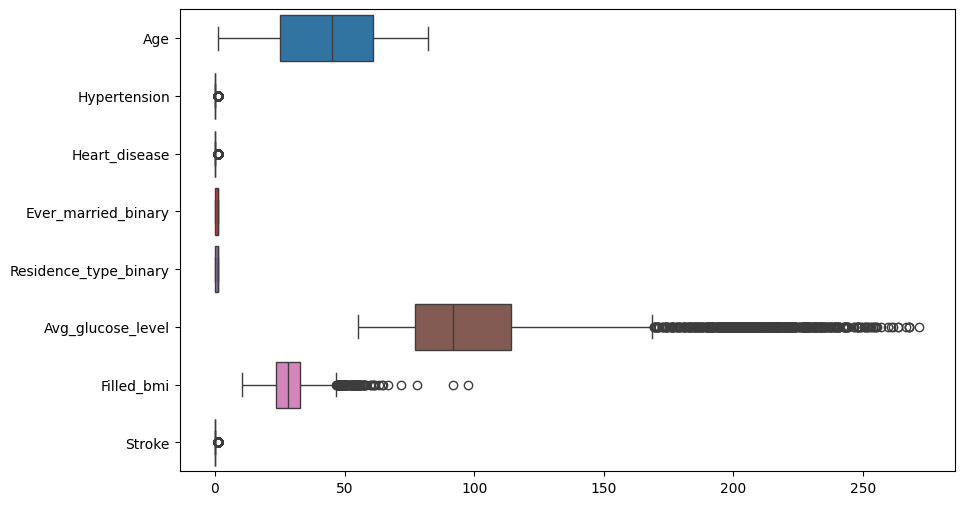

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, orient="h");

Checking from basic statistical view, we already can some aspects which can be analyzed further. Our data is sample of patients from age 0 till 82, while mean shows 45. Of course, let's not forget that we average age to full number, so we don't have patients with 0.5 or 1.5 age. We also see that Hypertension, Heart_disease ant Stroke mostly have 0 as an answer which means No. Bmi shows an average of 28.1, while we have extreme outliers which are 97.6. Also, average glucose level on average shows 91.89 while also having extreme outliers - 271.74. We will come back to these outliers if needed in ML part, for now we can move forward in our analysis.

### Stroke distribution over the patients 

From the dataset, we know that it contains a sample of patients. This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status.

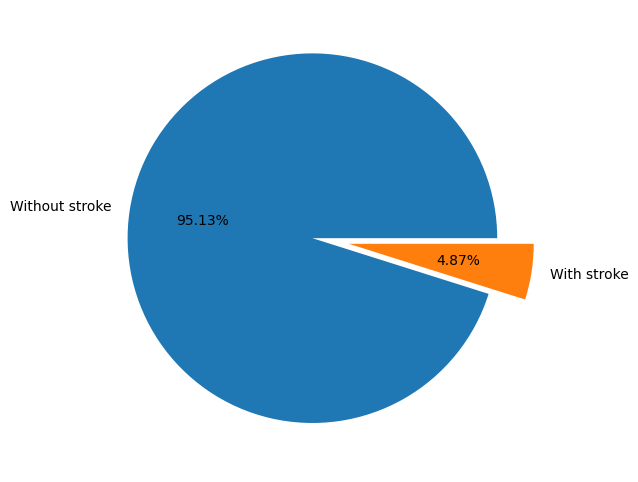

In [16]:
# Set up plot
plt.figure(figsize=(10, 6))

# Plot
plt.pie(
    x=df["Stroke"].value_counts(), 
    labels=[
        "Without stroke", 
        "With stroke"], 
    autopct='%1.2f%%', 
    explode=[0.1, 0.1]);

We can see that our data is not balanced, we have only 4.9% of patients with stroke in our dataset. This will have impact in our ML model. 

### Stroke Distribution Over Gender And Age

<Figure size 1000x600 with 0 Axes>

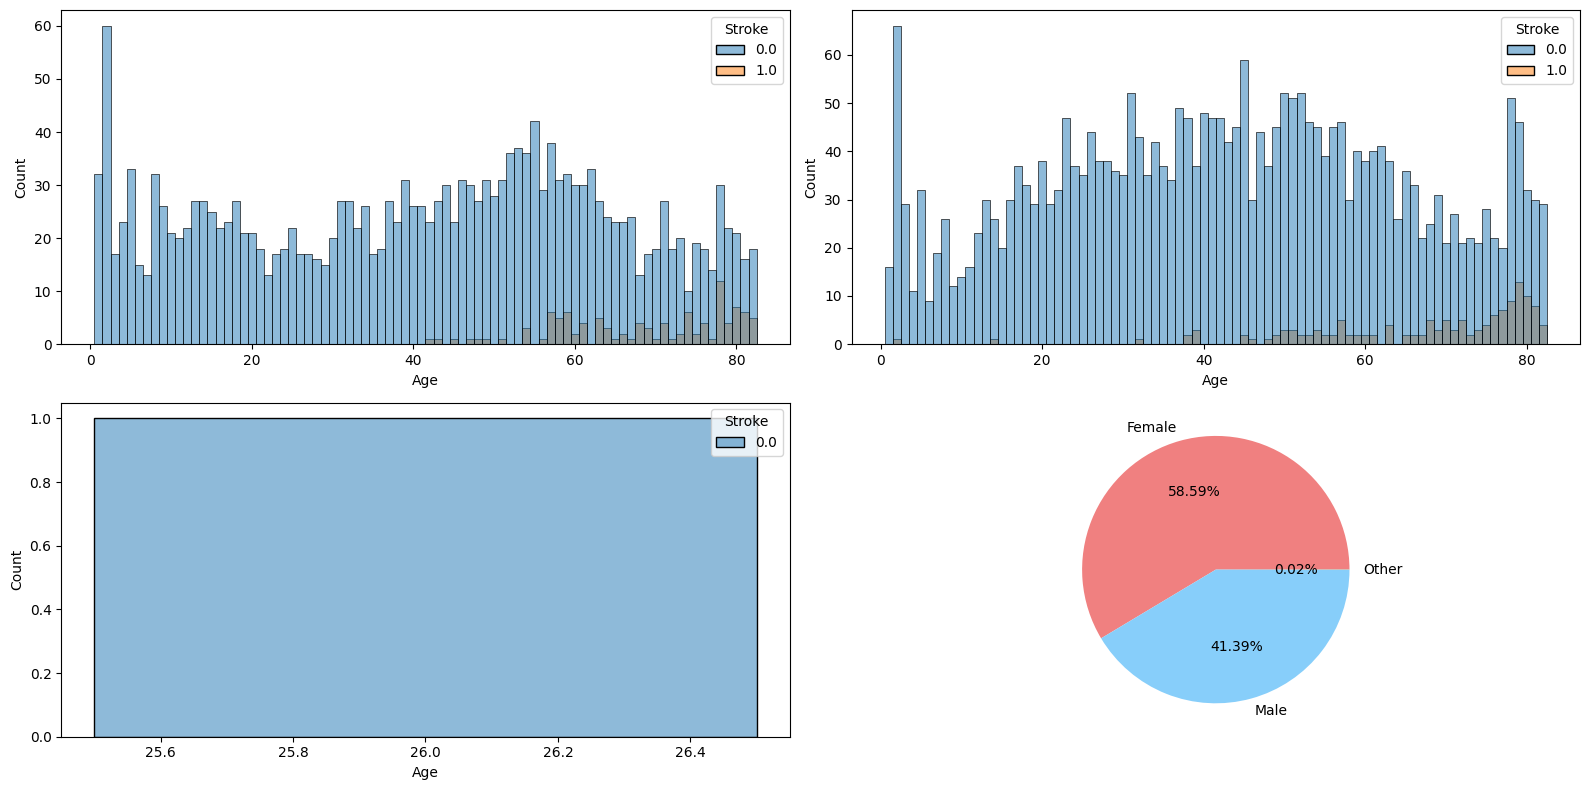

<Figure size 640x480 with 0 Axes>

In [17]:
# Set up variables
gender_counts = df["Gender"].value_counts()
genders = ["Female", "Male", "Other"]
pie_colors = ['lightcoral', 'lightskyblue', 'lightgreen']

# Set up subplots
plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# Plots
axes[1, 1].pie(
    x=gender_counts, 
    labels=genders, 
    autopct='%1.2f%%', 
    colors=pie_colors)

# Example usage
plot_gender_histograms(df, axes)
plt.tight_layout()
plt.show()

# Axes
axes[0, 0].set_title('Gender Distribution Pie Chart')
axes[0, 1].set_title('Male Distribution Over Age')
axes[1, 0].set_title('Female Distribution Over Age')
axes[1, 1].set_title('Other Distribution Over Age')

plt.tight_layout();

<li>58.59% of our data consists of Females patients.</li>
<li>41.39% of our data consists of Male patients.</li>
<li>0.02% which is one patient is Other.</li>
<li>Other gender patient don't have stroke.</li>
<li>Male patients have almost normally distributed over the age.</li>
<li>Female patients have bell shape distribution over the age.</li>
<li>For both Male and Female, we can see that stroke change is getting higher with the older age.</li>

As age have higher correlation with stroke, let's check how Bmi and Average glucose level change over age.

### Age Distribution Over Average Glucose Level And Bmi 

<Figure size 1000x600 with 0 Axes>

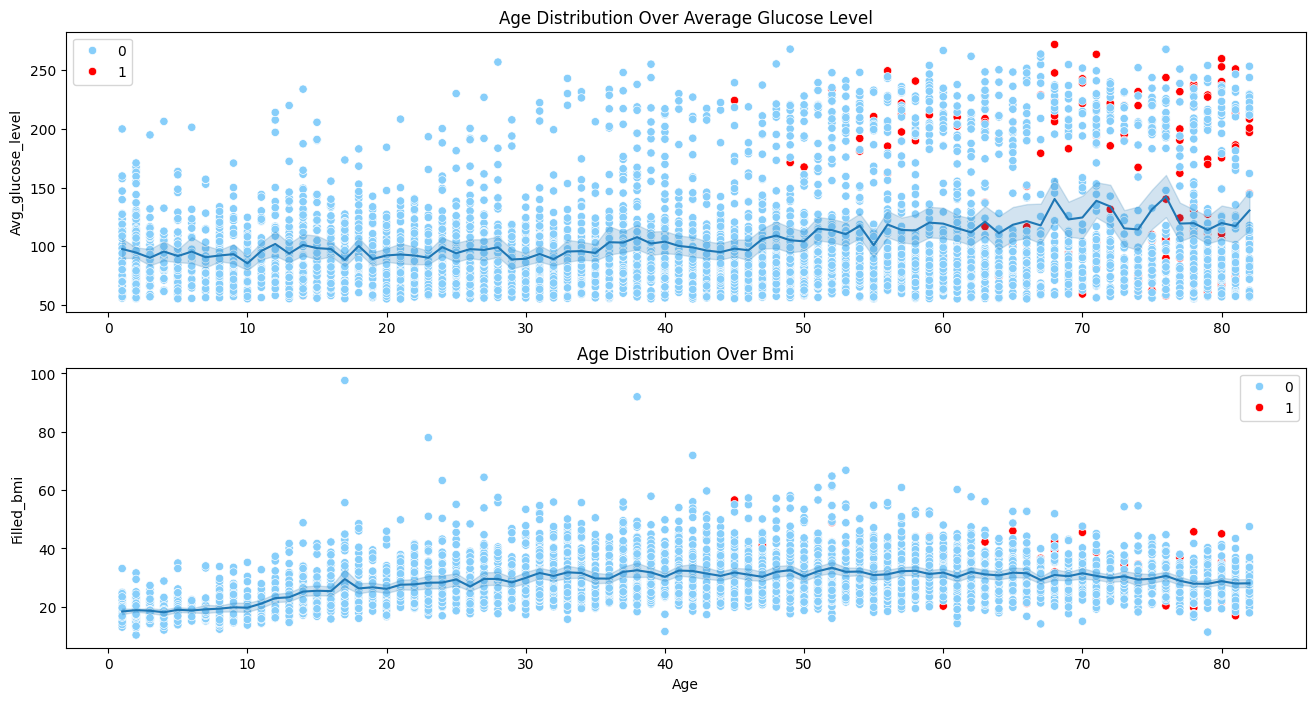

In [18]:
# Set up subplots
plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Plots
sns.scatterplot(
    data=df, 
    x="Age", 
    y="Avg_glucose_level", 
    hue="Stroke", 
    ax=axes[0], 
    palette=["lightskyblue", "red"])

sns.lineplot(
    data=df, 
    x="Age", 
    y="Avg_glucose_level", 
    ax=axes[0])


sns.scatterplot(
    data=df, 
    x="Age", 
    y="Filled_bmi", 
    hue="Stroke", 
    ax=axes[1], 
    palette=["lightskyblue", "red"])

sns.lineplot(
    data=df, 
    x="Age", 
    y="Filled_bmi", 
    ax=axes[1])

# Axes
axes[0].set_title("Age Distribution Over Average Glucose Level")
axes[0].set_xlabel("")
axes[1].set_title("Age Distribution Over Bmi");

<li>Range of Avg_glucose_level increase with age. Patients who are younger than 40 average glucose level stays at 100, for older patients level average level increase up to 150.</li>
<li>Older Patients with Avg_glucose_level have higher change for Stroke.</li>
<li>Bmi level rise till 40, from 40 to 50 stay almost at same value and from 50 it starts lowering.</li>
<li>We have the high number of overweight patients, few of them having BMI higher than 60.</li>
<li>We can see more patients with high bmi tend to have stroke more often.</li>

### Heart Disease And Hypertension Impact For Stroke Over Smoking Status

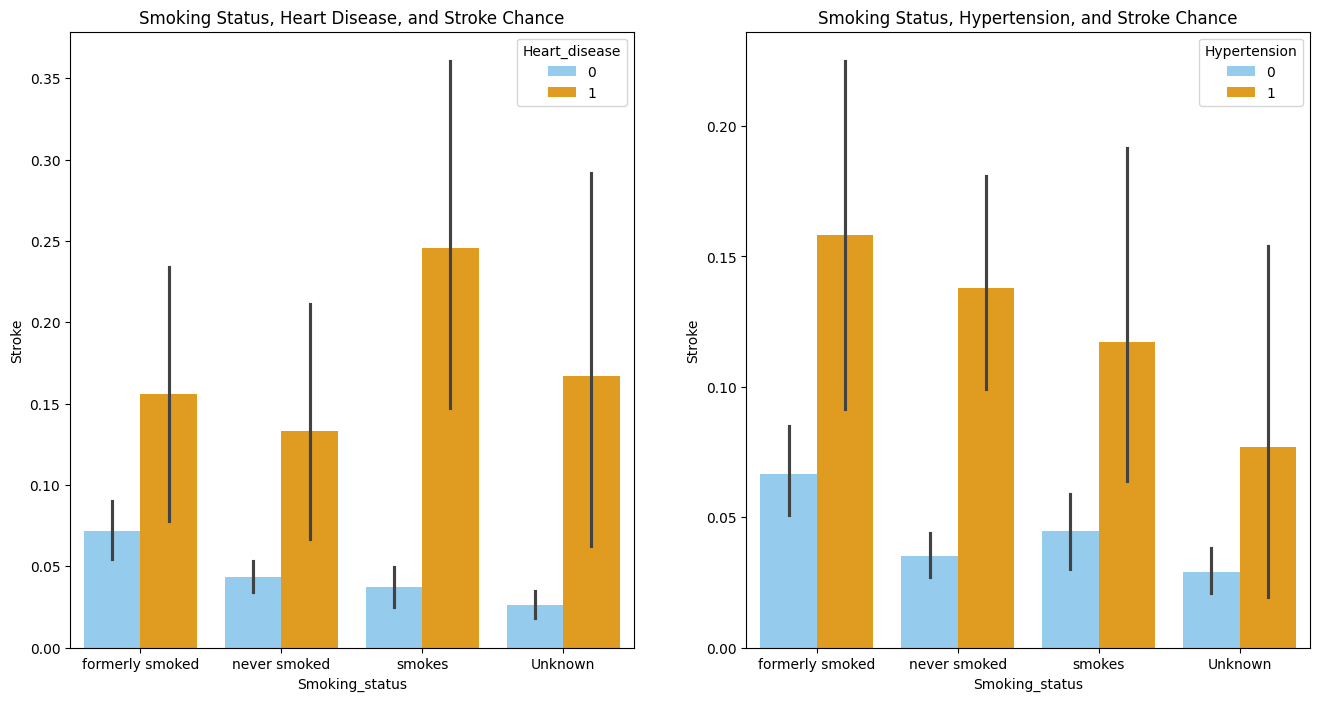

In [19]:
# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plots
sns.barplot(
    data=df, 
    x="Smoking_status", 
    y="Stroke", 
    hue="Heart_disease", 
    ax=axes[0], 
    palette=["lightskyblue", "orange"])

sns.barplot(
    data=df, 
    x="Smoking_status", 
    y="Stroke", 
    hue="Hypertension", 
    ax=axes[1], 
    palette=["lightskyblue", "orange"])

# Axes
axes[0].set_title("Smoking Status, Heart Disease, and Stroke Chance")
axes[1].set_title("Smoking Status, Hypertension, and Stroke Chance");

<b>Heart disease</b>
<li>Patients who smokes overall have the highest chance of getting stroke while having hearth disease. It goes from 15% to 36% while average stays at 24%</li>
<li>Lowest chance of stroke have non-smoker patients with 13% chance, but from other hand we can see that if patient don't have hearth disease it has slightly bigger chance that smokers.</li>
<li>Also we can see that smoker whiskers for stroke are higher than non-smoker, it is possible that they both are equal if they don't have hearth disease.</li>
<li>Formerly smoking patients on average have higher change of stroke than non-smoking patients for both groups of patients with and without hearth disease.</li>
<li>Unknown patients have the lowest chance of stroke, while not having disease but second to the highest chance of stroke with hearth disease. But we can't trust these values, as we don't know exactly if they smoke or not.</li>
<li>Chances of stroke increase almost 10 times if the patient is a smoker and have heart disease. </li>

<b>Hypertension</b>
<li>Smokers or formerly smokers have slightly higher chance of stroke while not having hypertension than not smokers or unknown patients.</li>
<li>If a patient have hypertension, chances of stroke increase almost double on average for all groups.</li>
<li>Non smoker patients have similar chance of stroke than smokers of formerly smokers if patient have hypertension</li>

<b>Sum up</b>
<li>There seems to be a trend indicating that individuals who currently smoke have a higher chance of stroke compared to those who never smoked or formerly smoked.</li>
<li>Individuals with heart disease consistently have a higher risk of stroke across all smoking categories compared to those without heart disease.</li>
<li>Similar to heart disease, individuals with hypertension have a higher risk of stroke compared to those without hypertension.</li>

#### Feature Correlation

Before moving to ML part let's check how our features correlate as highly correlated features can make it challenging to interpret the importance of individual features.

In [20]:
# Encode features
df_one_hot_encoded = pd.get_dummies(
    df, columns=['Gender', 'Work_type', 'Smoking_status'])

In [21]:
# Transform bool types to int
for col in df_one_hot_encoded.columns:
    if df_one_hot_encoded[col].dtype == 'bool':
        df_one_hot_encoded[col] = df_one_hot_encoded[col].astype(int)

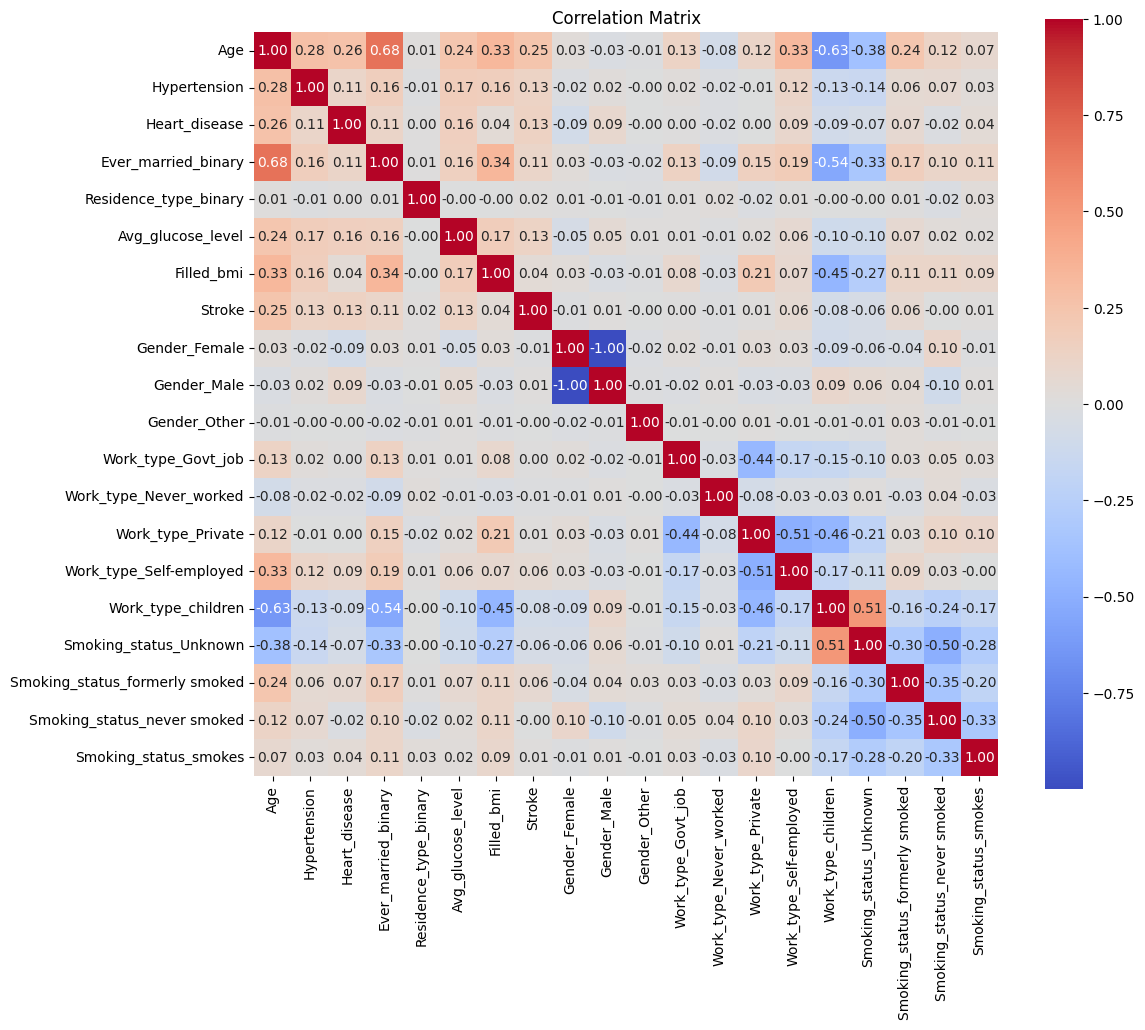

In [22]:
correlation_matrix = df_one_hot_encoded.corr()
plt.figure(figsize=(12, 10))

# Plot
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    square=True)

# Axes
plt.title('Correlation Matrix')
plt.show()

<li>We have small correlation with Self employed and Age.</li>
<li>Patients working in Private Sector have positive Bmi correlation.</li>
<li>Patients who have married before also correlate with Bmi.</li>

After encoding our features, we can see additional insight. While main feature Stroke is very little correlation with features, we still see some positive values between, one of the biggest correlation is 0.25 with Age, but it is still quite small. 

### Does Smoking Status Effect Stroke Chance

<li>Target population: Patients from The Johns Hopkins Hospital</li>
<li>Significance level: α = 0.05</li>
<li>Null hypothesis: There is a significant association between smoking status and stroke occurrence.</li>
<li>Alternative hypothesis: There is no significant association between smoking status and stroke chance</li>

Assumption
<li>Assumption 1: Both variables are categorical.</li>
<li>Assumption 2: All observations are independent.</li>
<li>Assumption 3: Cells in the contingency table are mutually exclusive.</li>
<li>Assumption 4: Expected value of cells should be 5 or greater in at least 80% of cells.</li>

We will check hypothesis between patient who have ever smoked ant never smoked before.

In [23]:
# Create additional dataframe for hypothesis testing
df_have_smoked = df[df['Smoking_status'] != 'Unknown'].copy()
df_have_smoked["Smoking_status"] = df_have_smoked["Smoking_status"].replace("formerly smoked", "smokes")


Chi-Square Statistic: 5.858167891171229
P-value: 0.015504925057129103
Degrees of Freedom: 1
Expected Frequencies Table:
[[1784.82557487  107.17442513]
 [1579.17442513   94.82557487]]


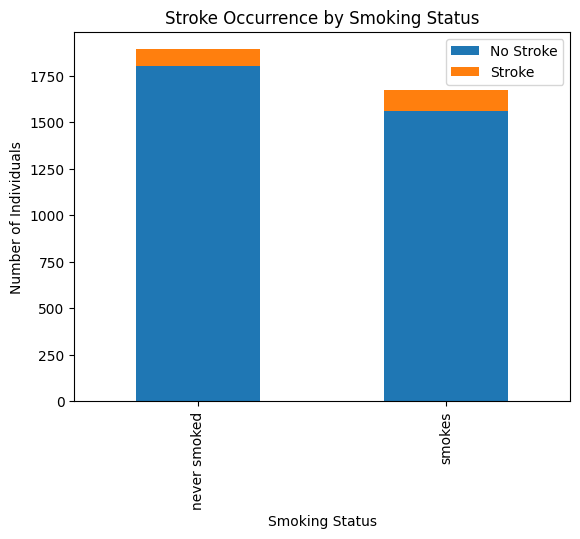

Reject the null hypothesis: There is a significant association between smoking status and stroke occurrence.


In [24]:
# Seperate dataframe for test
contingency_table = pd.crosstab(
    df_have_smoked['Smoking_status'], 
    df_have_smoked['Stroke'])

# Chi-Square Test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Results
print("\nChi-Square Statistic:", chi2_stat)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

# Plot
contingency_table.plot(
    kind='bar', 
    stacked=True)
plt.title('Stroke Occurrence by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Number of Individuals')
plt.legend(['No Stroke', 'Stroke'])
plt.show()

# Hypothesis
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant association between smoking status and stroke occurrence.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between smoking status and stroke occurrence.")

As we can see, there are big difference between smoker and non-smoker. Smoker have bigger chance to get stroke.

## Can We Predict If Patient Will Get Stroke?

As we know our data consists of different data types, we will get list of numerical and categorical column names, so we can use them later.

In [25]:
num_columns = ["Age", "Hypertension", "Heart_disease", 
               "Ever_married_binary", "Residence_type_binary", 
               "Avg_glucose_level", "Filled_bmi"]

cat_columns = ["Gender", "Work_type", "Smoking_status"]

Now we can split our patient data to train and test datasets, but before than we will split it to data and target.

In [26]:
data = df.drop("Stroke", axis=1)
target = df["Stroke"]

In [27]:
x_train, x_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42)

In EDA step, we saw that some of the features have widely scaled, so we will use StandardScaler to standardize features by removing the mean and scaling to unit variance. We also use OrdinalEncoder to encode categorical features as an integer array. We will wrap those steps to pipeline to make our models scalable. 

In [28]:
# Scale numerical columns
num_scaler = Pipeline(steps=[
    ('scaler', StandardScaler())  
])

# Encode categorical columns
cat_encoder = Pipeline(steps=[
    ('encoder', OrdinalEncoder(
        handle_unknown='use_encoded_value', 
        unknown_value=-1))  
])

# Combinie numeric and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_scaler, num_columns),
        ('cat', cat_encoder, cat_columns)
    ],
    remainder='passthrough'  
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Age', 'Hypertension', 'Heart_disease',
                                  'Ever_married_binary',
                                  'Residence_type_binary', 'Avg_glucose_level',
                                  'Filled_bmi']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Gender', 'Work_type', 'Smoking_status'])])

We already imported ML models and parameters from machine_learning_models file, so we can proceed further to combining our models with SMOTE which will handle our Stroke data imbalance, also we will use RandomizedSearchCV which will perform most of the Hyperparameter tuning for us and finally fit our models and check results of them. 

We will use 3 models:
<ul>LogisticRegression</ul>
<li>Logistic Regression is a straightforward model that is easy to understand and interpret. It provides clear insights into feature importance through its coefficients.</li>
<li>With the class_weight='balanced' parameter, Logistic Regression can handle class imbalance by adjusting the weights inversely proportional to class frequencies.</li>
<ul>RandomForestClassifier</ul>
<li>Random Forest is an ensemble method that combines multiple decision trees to improve accuracy and robustness, reducing the risk of overfitting compared to individual decision trees.</li>
<li>By setting class_weight='balanced', Random Forest can mitigate the impact of class imbalance, though additional methods (like SMOTE) might still be needed.</li>
<li>Random Forest is effective for both classification and regression tasks, making it a versatile choice for various predictive modeling problems.</li>
<ul>GradientBoostingClassifier</ul>
<li>Gradient Boosting often provides state-of-the-art performance on structured/tabular data due to its iterative boosting process that reduces bias and variance.</li>
<li>It allows for fine-tuning through various hyperparameters (e.g., learning rate, number of estimators, max depth), providing flexibility to balance bias-variance trade-off.</li>

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.76      0.85       960
           1       0.17      0.76      0.27        62

    accuracy                           0.76      1022
   macro avg       0.57      0.76      0.56      1022
weighted avg       0.93      0.76      0.82      1022

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Random Forest
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       960
           1       0.20      0.11      0.14        62

    accuracy                           0.92      1022
   macro avg       0.57      0.54      0.55      1022
weighted avg       0.90      0.92      0.91      1022

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Gradient Boosting
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       960
  

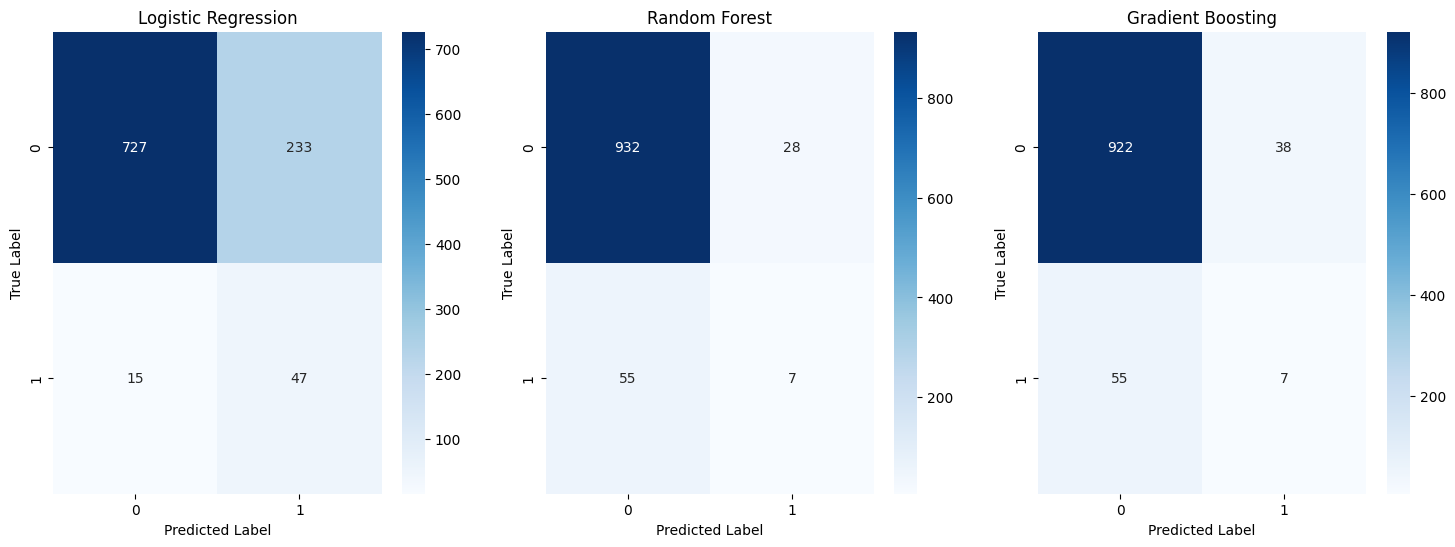

In [32]:
# Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Prediction
results = []
place = 0
for model_name, model in ml_models.items():
    # Create a pipeline that combines preprocessing, SMOTE and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])
    
    # Load Hyperparameters for model
    param_grid = ml_models_parameters[model_name]

    # Perform Hyperparameter search
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=min(5, len(param_grid)),
        cv=10,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    # Calculate time for fiting of model
    start_time = time.time()
    search.fit(x_train, y_train)
    end_time = time.time()

    # Get best model parameters and evaluate it
    best_model = search.best_estimator_
    y_pred = best_model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Store results
    results.append({
        "Model": model_name,
        "Best Parameters": search.best_params_,
        "Test Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": cm,
        "Time Taken (seconds)": end_time - start_time
    })
    print(model_name)
    print(classification_report(y_test, y_pred))
    cm_matrix(cm=cm, place=place, model_name=model_name)
    place += 1

    # Deploy best model
    joblib.dump(best_model, f"models/{model_name}.pkl")

results_df = pd.DataFrame(results)

In [30]:
results_df

,Model,Best Parameters,Test Accuracy,Precision,Recall,F1 Score,Confusion Matrix,Time Taken (seconds)
0,Logistic Regression,"{'model__class_weight': 'balanced', 'model__C'...",0.757339,0.167857,0.758065,0.274854,"[[727, 233], [15, 47]]",2.220091
1,Random Forest,"{'model__n_estimators': 100, 'model__min_sampl...",0.918787,0.200000,0.112903,0.144330,"[[932, 28], [55, 7]]",6.743520
2,Gradient Boosting,"{'model__n_estimators': 100, 'model__max_depth...",0.909002,0.155556,0.112903,0.130841,"[[922, 38], [55, 7]]",6.270413


<li>Logistic Regression with balanced class weights performed reasonably well on the minority class, with a recall of 0.758. This indicates that the model is good at identifying the positive class, but at the cost of many false positives (as indicated by lower precision).</li>

<li>Random Forest also used balanced class weights but struggled to identify the minority class, with a recall of only 0.113. While overall accuracy is high (0.919), the low recall and F1 score indicate that it missed many positive cases.</li>

<li>Gradient Boosting performed similarly to Random Forest, with high overall accuracy but poor recall for the minority class. The precision and F1 score are slightly lower than Random Forest, indicating that it also struggled with class imbalance.</li>

## Summary

The analysis focuses on a patient dataset with no duplicate values and an initial cleaning process that addressed missing BMI values and enhanced column readability. Key findings include:

<li>The dataset includes patients aged 0 to 82, with a mean age of 45.</li>
<li>58.59% of patients are female, 41.39% male, and 0.02% other.</li>
<li>Common conditions such as hypertension, heart disease, and stroke mostly show "No" responses.</li>
<li>Average BMI is 28.1, with significant outliers, and average glucose levels are 91.89, also with extreme values.</li>
<li>Stroke risk increases with age, particularly for patients over 40, with smokers having the highest risk (15%-36%) compared to non-smokers (13%).</li>
<li>Patients with heart disease or hypertension consistently show higher stroke risk.</li>
<li>Logistic Regression performed well in identifying positive stroke cases, while Random Forest and Gradient Boosting struggled with minority class detection despite high overall accuracy.</li>

## Recommendations

<li><b>Health Programs Targeting Smokers:</b> Create programs to help people quit smoking, highlighting how smoking increases the risk of strokes, especially for those with heart disease or high blood pressure.</li>
<li><b>Preventive Health Campaigns:</b> Launch campaigns that aims of the importance of keeping BMI and glucose levels in check, particularly for people over 40, to reduce the chances of having a stroke.</li>
<li><b>Regular Health Screenings:</b> Start regular health checks for high blood pressure and heart disease, focusing on high-risk groups, to catch and treat these issues early.</li>

## Suggestion For Improvement

<li>Further tuning of hyperparameters for Random Forest and Gradient Boosting might help improve their recall.</li>
<li>Try ensemble methods that combine the strengths of different models.</li>